# SNN Quickstart

Una SNN codifica una base de conocimiento en una red neuronal.
Para utilizarla es necesario definir la estructura de la base de conocimientos,
entidades (`Entity`) y relaciones (`Relation`).
Luego se entrena con tuplas de la base de conocimiento.

In [51]:
from snn import SNN, Entity, Relation
from keras.layers import Input, Dense
from keras.models import Sequential
from snn.utils import draw

En este ejemplo usaremos una "base de conocimiento" ficticia, simplemente generaremos aleatoriamente personas y filmes y relaciones entre ellos.

In [52]:
Person = Entity("Person")
Movie = Entity("Movie")

director = Relation("director", Person, Movie)
actor = Relation("actor", Person, Movie)

Ahora construimos la SNN. Una SNN es parte de una red neuronal, por lo que puede ser usada en un modelo funcional de `keras` (no secuencial).
Primero construimos definimos la SNN, pasando la lista de entidades y relaciones.

In [53]:
snn = SNN(entities=[Person, Movie], relations=[director, actor])

Ahora podemos usar esta instancia _como si fuera_ una capa de `keras`, aunque técnicamente no hereda de `Layer`.

In [54]:
x = Input(shape=(100,), name="input")
y = snn(x)

Podemos definir la entrada y salida de la SNN de cualquier forma. En este caso `x` es un vector _one-hot_ de entrada, pero pudiera ser un _embedding_ o cualquier arquitectura más compleja. Lo importante es ser consistente a la hora de entrenar la SNN con el tipo de la entrada.

En `y` tendremos la salida de la SNN que corresponde al _embedding_ de cada una de las relaciones y entidades visto como una concatenación. A partir de este tensor podemos seguir construyendo la red neuronal como nos haga falta, si el problema es de clasificación o regresión, etc.

Para entrenar la SNN usamos el método `snn.build` que nos devuelve un modelo listo para entrenar (ya compilado con la función de pérdida adecuada). Este método recibe `x`, la entrada original de la red, pues la SNN debe aprender a mapear cualquier entrada.

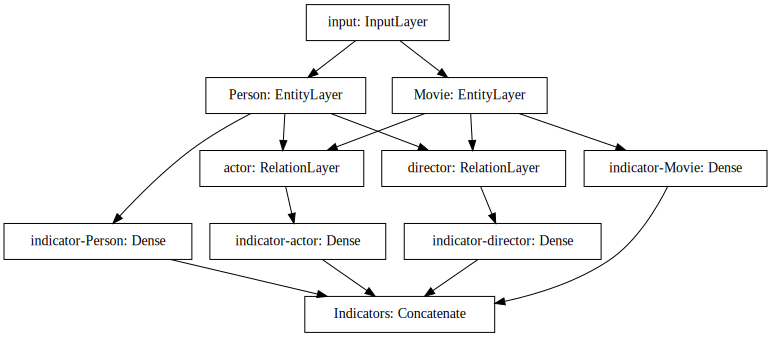

In [55]:
snn_model = snn.build(x, optimizer='adam')
draw(snn_model)

In [56]:
snn_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 100)          0                                            
__________________________________________________________________________________________________
Person (EntityLayer)            (None, 32)           4288        input[0][0]                      
__________________________________________________________________________________________________
Movie (EntityLayer)             (None, 32)           4288        input[0][0]                      
__________________________________________________________________________________________________
director (RelationLayer)        (None, 64)           6272        Person[0][0]                     
                                                                 Movie[0][0]                      
__________

Ahora por simplicidad vamos a generar una "base de conocimiento" dummy, donde las personas `1`, `2`, etc., estarán relacionadas con los filmes `1`, `2`, etc., de forma aleatoria.

In [57]:
import random

people = list(range(50))
movies = list(range(50))

directors = [random.choice(people) for m in movies]
actors = [random.sample(people, 10) for m in movies]

A partir de nuestra "base de conocimientos" generamos _batches_ de entrenamiento para la SNN. Observar como cada ejemplo entrenante consiste en un par de índices (persona, filme) y tres anotaciones: las clases y la relación a predecir. El método `snn.map` convierte una lista de anotaciones (`Entity`s o `Relation`s) en una matriz _one-hot_ usando un mapping interno de la SNN de cada entidad o relación a un índice en la matriz.

In [58]:
from keras.utils import to_categorical
import numpy as np

def random_batch(size=128):
    x = []
    y = []
    
    for i in range(size):
        movie = random.choice(movies)
        if random.uniform(0,1) > 0.5:
            person = directors[movie]
            relation = director
        else:
            person = random.choice(actors[movie])
            relation = actor
            
        x.append([person, movie + len(people)])
        y.append([Person, Movie, relation])
         
            
    return to_categorical(x, 100).sum(axis=1), snn.map(y)

def random_batches(size=128):
    while True:
        yield random_batch(size)

In [59]:
def accuracy():
    x,y = random_batch()
    yp = snn_model.predict(x)
    yp = (yp>0.5).astype(int)
    return (y == yp).astype(float).mean()

Veamos la precisión de la SNN antes de entrenar...

In [60]:
accuracy()

0.513671875

In [61]:
snn_model.fit_generator(generator=random_batches(), steps_per_epoch=1000, epochs=1)

Epoch 1/1
1000/1000 [==============================] - 4s 4ms/step - loss: 0.2633


Y después de entrenar...

In [62]:
accuracy()

0.9140625